In [1]:
import numpy as np
import cv2
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [2]:
img_path = 'sample_images/0102.png'
image = cv2.imread(img_path)


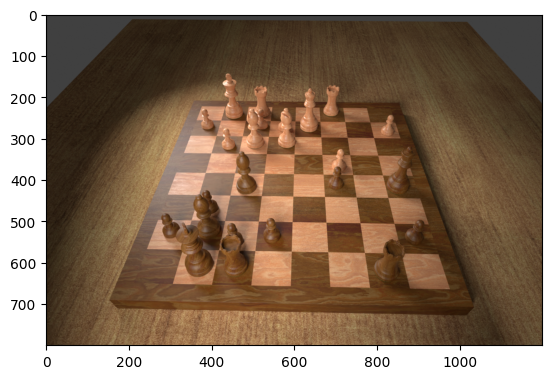

In [3]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


In [4]:
def _absolute_angle_difference(x, y):
    diff = np.mod(np.abs(x - y), 2 * np.pi)
    # angles are cyclical so return smaller of the two possible differences
    return np.min(np.stack([diff, np.pi - diff], axis=-1), axis=-1)


def _get_intersection(rho1, theta1, rho2, theta2):
    cos_t1 = np.cos(theta1)
    cos_t2 = np.cos(theta2)
    sin_t1 = np.sin(theta1)
    sin_t2 = np.sin(theta2)
    x = (sin_t1 * rho2 - sin_t2 * rho1) / (cos_t2 * sin_t1 - cos_t1 * sin_t2)
    y = (cos_t1 * rho2 - cos_t2 * rho1) / (sin_t2 * cos_t1 - sin_t1 * cos_t2)
    return x, y


def _fix_negative_rho(lines: np.ndarray) -> np.ndarray:
    lines = lines.copy()
    neg_rho_mask = lines[..., 0] < 0
    lines[neg_rho_mask, 0] = -lines[neg_rho_mask, 0]
    lines[neg_rho_mask, 1] = lines[neg_rho_mask, 1] - np.pi
    return lines


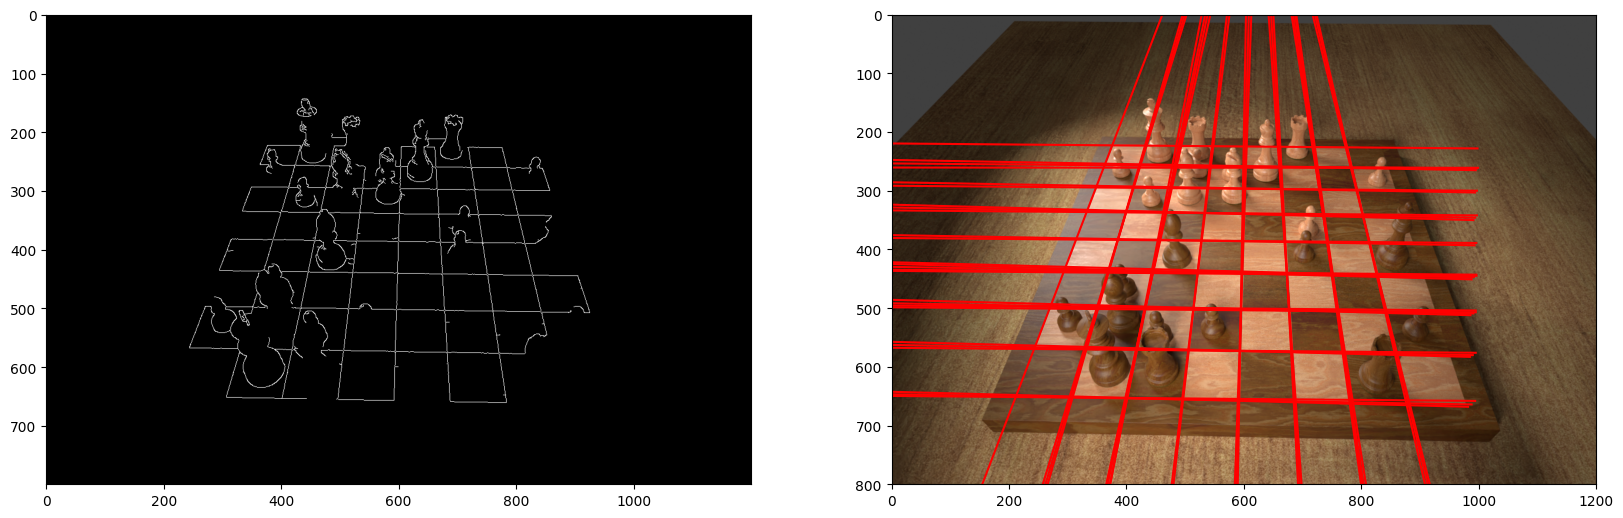

In [5]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(gray, 90, 400)
lines = cv2.HoughLines(edged, 1, np.pi / 360, 100)
lines = lines.squeeze(axis=-2)

# plot edged and lines next to each other
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(edged, cmap="gray")
ax[1].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
for rho, theta in lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * -b)
    y1 = int(y0 + 1000 * a)
    x2 = int(x0 - 1000 * -b)
    y2 = int(y0 - 1000 * a)
    ax[1].plot([x1, x2], [y1, y2], "r-")
ax[1].set_xlim([0, image.shape[1]])
ax[1].set_ylim([image.shape[0], 0])
plt.show()


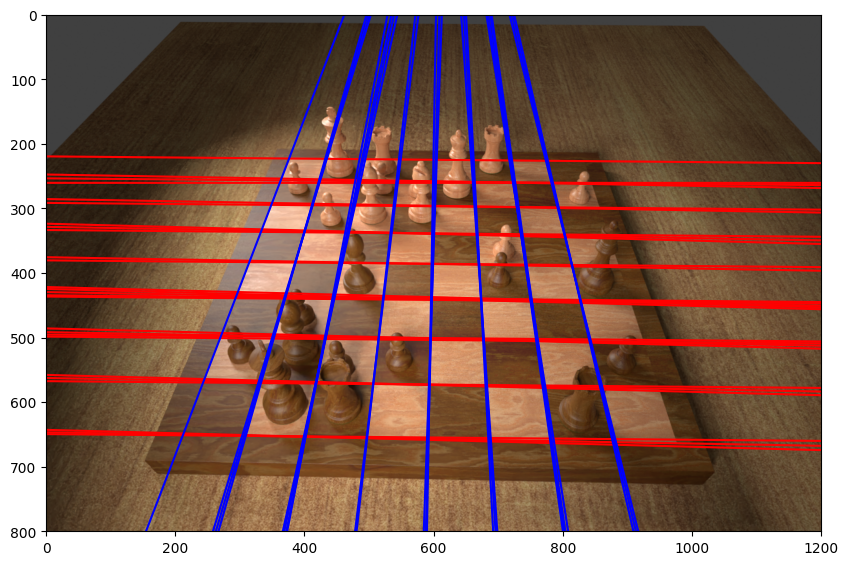

In [6]:
# cluster lines based on their angles
lines = _fix_negative_rho(lines)
thetas = lines[..., 1].reshape(-1, 1)
distance_matrix = pdist(thetas, metric=_absolute_angle_difference)
distance_matrix = squareform(distance_matrix)

clustering = AgglomerativeClustering(metric="precomputed", linkage="complete", n_clusters=2)
clusters = clustering.fit_predict(distance_matrix)

# determine which cluster is the horizontal lines and which is the vertical lines
angle_with_y_axis = _absolute_angle_difference(thetas, 0.0)
if angle_with_y_axis[clusters == 0].mean() > angle_with_y_axis[clusters == 1].mean():
    hcluster, vcluster = 0, 1
else:
    hcluster, vcluster = 1, 0

horizontal_lines = lines[clusters == hcluster]
vertical_lines = lines[clusters == vcluster]

# plot horizontal lines in red and vertical lines in blue
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
for rho, theta in horizontal_lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 10000 * -b)
    y1 = int(y0 + 10000 * a)
    x2 = int(x0 - 10000 * -b)
    y2 = int(y0 - 10000 * a)
    ax.plot([x1, x2], [y1, y2], "r-")
for rho, theta in vertical_lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 10000 * -b)
    y1 = int(y0 + 10000 * a)
    x2 = int(x0 - 10000 * -b)
    y2 = int(y0 - 10000 * a)
    ax.plot([x1, x2], [y1, y2], "b-")
ax.set_xlim([0, image.shape[1]])
ax.set_ylim([image.shape[0], 0])
plt.show()


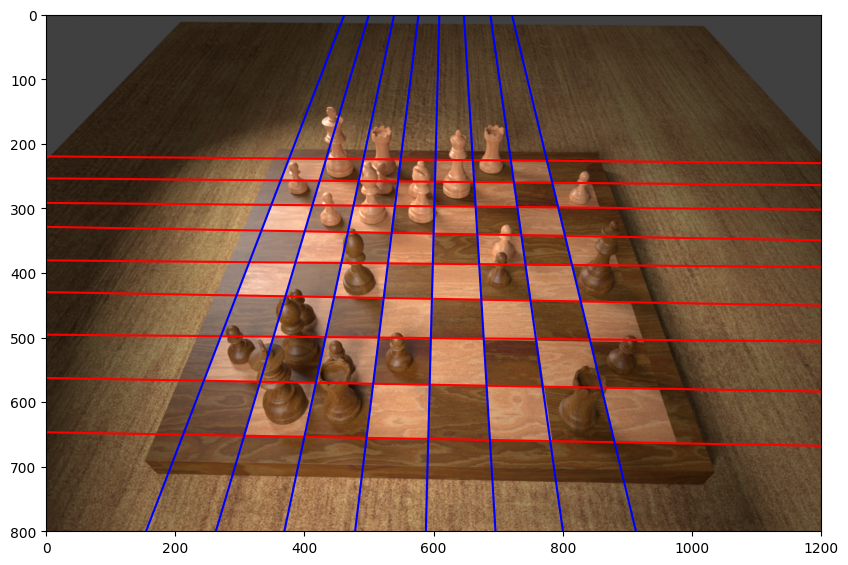

In [7]:
# find mean vertical line
mean_vertical_rho, mean_vertical_theta = vertical_lines.mean(axis=0)
rho, theta = np.moveaxis(horizontal_lines, -1, 0)
intersections = _get_intersection(rho, theta, mean_vertical_rho, mean_vertical_theta)
intersections = np.stack(intersections, axis=-1)

clustering = DBSCAN(eps=12, min_samples=1)
clusters = clustering.fit(intersections)

# filter horizontal lines
filtered_lines = []
for c in range(clusters.labels_.max() + 1):
    lines_in_cluster = horizontal_lines[clusters.labels_ == c]
    rho = lines_in_cluster[..., 0]
    median = np.argsort(rho)[len(rho) // 2]
    filtered_lines.append(lines_in_cluster[median])
horizontal_lines = np.stack(filtered_lines, axis=0)

# find mean horizontal line
mean_horizontal_rho, mean_horizontal_theta = horizontal_lines.mean(axis=0)
rho, theta = np.moveaxis(vertical_lines, -1, 0)
intersections = _get_intersection(rho, theta, mean_horizontal_rho, mean_horizontal_theta)
intersections = np.stack(intersections, axis=-1)

clusters = clustering.fit(intersections)

# filter vertical lines
filtered_lines = []
for c in range(clusters.labels_.max() + 1):
    lines_in_cluster = vertical_lines[clusters.labels_ == c]
    rho = lines_in_cluster[..., 0]
    median = np.argsort(rho)[len(rho) // 2]
    filtered_lines.append(lines_in_cluster[median])
vertical_lines = np.stack(filtered_lines, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# show horizontal lines
for rho, theta in horizontal_lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 10000 * -b)
    y1 = int(y0 + 10000 * a)
    x2 = int(x0 - 10000 * -b)
    y2 = int(y0 - 10000 * a)
    ax.plot([x1, x2], [y1, y2], "r-")

# show vertical lines
for rho, theta in vertical_lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 10000 * -b)
    y1 = int(y0 + 10000 * a)
    x2 = int(x0 - 10000 * -b)
    y2 = int(y0 - 10000 * a)
    ax.plot([x1, x2], [y1, y2], "b-")

ax.set_xlim([0, image.shape[1]])
ax.set_ylim([image.shape[0], 0])
plt.show()


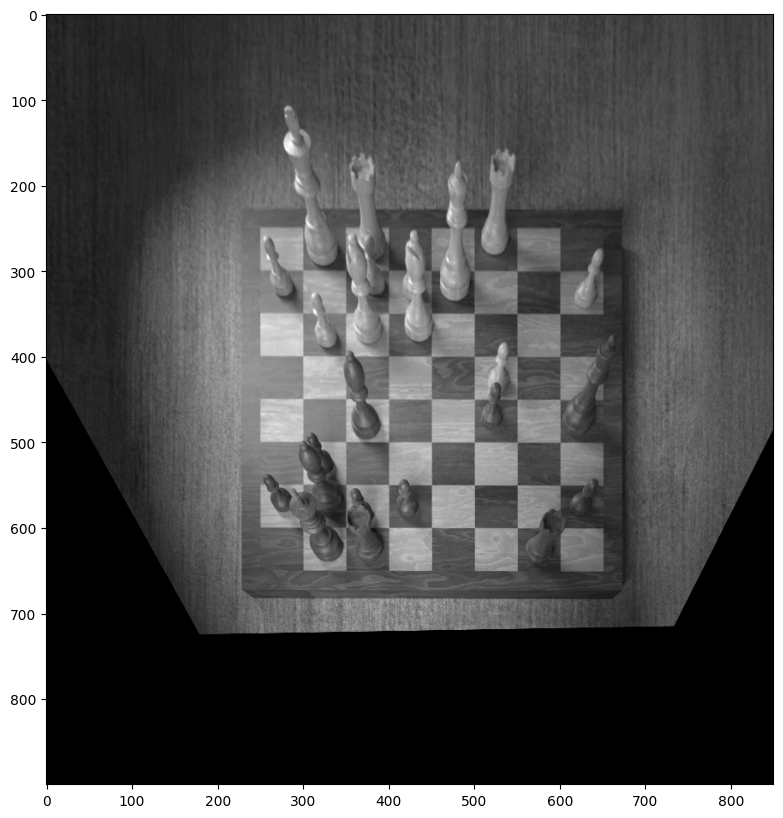

In [8]:
# get intersection points
all_intersections = []
for hline in horizontal_lines:
    for vline in vertical_lines:
        rho1, theta1 = hline
        rho2, theta2 = vline
        x, y = _get_intersection(rho1, theta1, rho2, theta2)
        all_intersections.append((x, y))
all_intersections = np.array(all_intersections)
all_intersections = np.concatenate([all_intersections, np.ones((*all_intersections.shape[:-1], 1))], axis=-1)

# RANSAC
iterations = 0
best_inliers = []
best_candidate_mapping = []
while iterations < 200 or len(best_inliers) < 30:
    # randomly select 2 horizontal and 2 vertical lines
    h_rand_indices = np.random.choice(len(horizontal_lines), 2, replace=False)
    h_rand_indices = np.sort(h_rand_indices)
    v_rand_indices = np.random.choice(len(vertical_lines), 2, replace=False)
    v_rand_indices = np.sort(v_rand_indices)
    rand_horizontal = horizontal_lines[h_rand_indices]
    rand_vertical = vertical_lines[v_rand_indices]

    rand_horizontal = rand_horizontal[np.argsort(rand_horizontal[..., 0])]
    rand_vertical = rand_vertical[np.argsort(rand_vertical[..., 0])]

    # get the intersection points
    top_horizontal = rand_horizontal[0]
    bottom_horizontal = rand_horizontal[1]
    left_vertical = rand_vertical[0]
    right_vertical = rand_vertical[1]
    intersections = [
        _get_intersection(top_horizontal[0], top_horizontal[1], left_vertical[0], left_vertical[1]),  # top left
        _get_intersection(top_horizontal[0], top_horizontal[1], right_vertical[0], right_vertical[1]),  # top right
        _get_intersection(
            bottom_horizontal[0], bottom_horizontal[1], right_vertical[0], right_vertical[1]
        ),  # bottom right
        _get_intersection(
            bottom_horizontal[0], bottom_horizontal[1], left_vertical[0], left_vertical[1]
        ),  # bottom left
    ]
    intersections = np.array(intersections)

    for s_x in range(1, 9):
        for s_y in range(1, 9):
            dst = np.array([[0, 0], [s_x, 0], [s_x, s_y], [0, s_y]], dtype=np.float32)
            H, _ = cv2.findHomography(intersections, dst)

            inliers = []
            warped_points = set()
            candidate_mapping = []
            for p in all_intersections:
                # warp the point
                p_prime = p @ H.T
                p_prime = p_prime[..., :2] / p_prime[..., 2, np.newaxis]
                q = np.round(p_prime).astype(int)
                if tuple(q) in warped_points:
                    continue
                # L1 norm
                error = np.sum(np.abs(p_prime - q))
                if error < 0.05:
                    inliers.append(p)
                    warped_points.add(tuple(q))
                    candidate_mapping.append((p, q))
            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_candidate_mapping = candidate_mapping
    if iterations >= 500:
        break
    iterations += 1

intersections = np.array([p for p, _ in best_candidate_mapping])
warped_points = np.array([q for _, q in best_candidate_mapping])
# translate warped points
warped_points = warped_points - warped_points.min(axis=0) + 5
dst = warped_points * 50
# recompute the homography using the inliers
H, _ = cv2.findHomography(intersections, dst)

# use H to warp the image
SQUARE_SIZE = 50
H = np.array(H, dtype=np.float32)
max_size = (warped_points.max(axis=0) + 5) * SQUARE_SIZE
warped = cv2.warpPerspective(gray, H, (max_size[0], max_size[1]))
# plot the warped image
plt.figure(figsize=(10, 10))
plt.imshow(warped, cmap="gray")
plt.show()


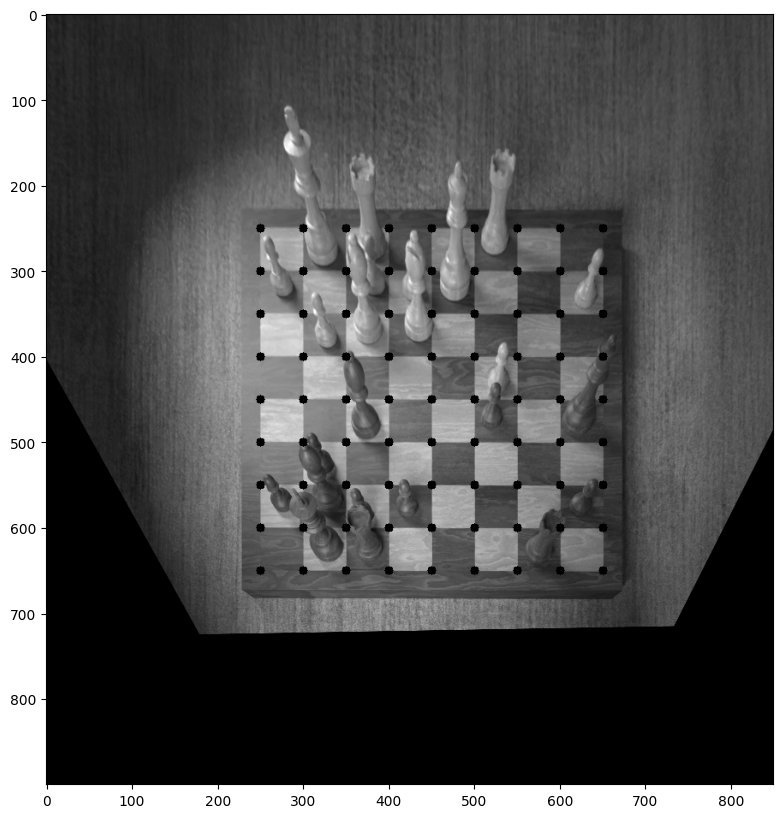

In [9]:
# infer missing lines
threshold = 2
w_x_min = warped_points[:, 0].min()
w_x_max = warped_points[:, 0].max()
w_y_min = warped_points[:, 1].min()
w_y_max = warped_points[:, 1].max()
w_x_diff = w_x_max - w_x_min
w_y_diff = w_y_max - w_y_min

# infer vertical lines
while w_x_diff > 8:
    # remove all points corresponding to the left/right columns
    remove_indices = np.where((warped_points[:, 0] == w_x_min) | (warped_points[:, 0] == w_x_max))[0]
    warped_points = np.delete(warped_points, remove_indices, axis=0)
    best_inliers = np.delete(best_inliers, remove_indices, axis=0)
    best_candidate_mapping = np.delete(best_candidate_mapping, remove_indices, axis=0)
    w_x_min = warped_points[:, 0].min()
    w_x_max = warped_points[:, 0].max()
    w_x_diff = w_x_max - w_x_min
while w_x_diff < 8:
    # horizontal sobel filter
    sobelx = np.abs(cv2.Sobel(warped.copy(), cv2.CV_64F, 1, 0, ksize=3))
    vertical_edges = cv2.Canny(sobelx.astype(np.uint8), 250, 500)
    # sum pixels on the vertical lines to the left and right of min and max x
    left_mid = (w_x_min - 1) * SQUARE_SIZE
    left_sum = np.sum(vertical_edges[:, left_mid - threshold : left_mid + threshold + 1])
    right_mid = (w_x_max + 1) * SQUARE_SIZE
    right_sum = np.sum(vertical_edges[:, right_mid - threshold : right_mid + threshold + 1])
    if left_sum > right_sum:
        # add left column
        w_x_min -= 1
    else:
        # add right column
        w_x_max += 1
    w_x_diff = w_x_max - w_x_min

# infer horizontal lines
while w_y_diff > 8:
    # remove all points corresponding to the top/bottom rows
    remove_indices = np.where((warped_points[:, 1] == w_y_min) | (warped_points[:, 1] == w_y_max))[0]
    warped_points = np.delete(warped_points, remove_indices, axis=0)
    best_inliers = np.delete(best_inliers, remove_indices, axis=0)
    best_candidate_mapping = np.delete(best_candidate_mapping, remove_indices, axis=0)
    w_y_min = warped_points[:, 1].min()
    w_y_max = warped_points[:, 1].max()
    w_y_diff = w_y_max - w_y_min
while w_y_diff < 8:
    # vertical sobel filter
    sobely = np.abs(cv2.Sobel(warped.copy(), cv2.CV_64F, 0, 1, ksize=3))
    horizontal_edges = cv2.Canny(sobely.astype(np.uint8), 250, 500)
    # sum pixels on the horizontal lines to the top and bottom of min and max y
    top_mid = (w_y_min - 1) * SQUARE_SIZE
    top_sum = np.sum(horizontal_edges[top_mid - threshold : top_mid + threshold, :])
    bottom_mid = (w_y_max + 1) * SQUARE_SIZE
    bottom_sum = np.sum(horizontal_edges[bottom_mid - threshold : bottom_mid + threshold, :])
    if top_sum > bottom_sum:
        # add top row
        w_y_min -= 1
    else:
        # add bottom row
        w_y_max += 1
    w_y_diff = w_y_max - w_y_min

# plot all intersections
intersections = np.zeros((9, 9, 2))
for row in range(w_y_min, w_y_max + 1):
    for col in range(w_x_min, w_x_max + 1):
        cv2.circle(warped, (col * SQUARE_SIZE, row * SQUARE_SIZE), 5, (0, 255, 0), -1)
        intersections[row - w_y_min, col - w_x_min] = [col * SQUARE_SIZE, row * SQUARE_SIZE]

plt.figure(figsize=(10, 10))
plt.imshow(warped, cmap="gray")
plt.show()


In [10]:
def get_position(boxes):
    # boxes is a 4*n 2d array that marks the 4 corners of the target box
    # return the bottom position, which is decided by the center of lower 1/3 of the box
    n = len(boxes)
    position = np.zeros((n,2))
    for i in range(n):
        x1, y1, x2, y2 = boxes[i]
        position[i][0] = (x1+x2)/2
        position[i][1] = y2 - (y2-y1)/6
    return position

def point_transformation(position, H):
    # H is a 3*3 transformation matrix
    n = len(position)
    points = np.hstack((position, np.ones((n, 1))))
    transformed_points = np.dot(points, H.T)
    transformed_points[:, 0] /= transformed_points[:, 2]
    transformed_points[:, 1] /= transformed_points[:, 2]
    result_points = transformed_points[:, :2]
    return result_points

def label_pieces(position, labels):
    label_map = {1:'r', 2:'n', 3:'b', 4:'k', 5:'q', 6:'p', 7:'R', 8:'N', 9:'B', 10:'K', 11:'Q', 12:'P'}
    outputs = []
    for i in range(len(position)):
        output = []
        output.append(label_map[(labels[i])])
        output.append(position[i][0])
        output.append(position[i][1])
        outputs.append(output)
    return outputs


In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
num_classes = 13 # 12 class + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
params = [p for p in model.parameters() if p.requires_grad]

if torch.cuda.is_available():
    model.load_state_dict(torch.load("models/best_model_ep5_s100_f11.0.pth"))
else:
    model.load_state_dict(torch.load("models/best_model_ep5_s100_f11.0.pth", map_location=torch.device('cpu')))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/Users/albertliu/Documents/uiuc/CS445/chess/env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

[['k', 359.4764404296875, 612.0532175699869], ['p', 456.1257019042969, 553.759765625], ['K', 452.3193054199219, 235.55165100097656], ['p', 301.7256774902344, 532.3075561523438], ['P', 708.663818359375, 371.3275451660156], ['R', 522.0142211914062, 239.0357666015625], ['P', 441.7698974609375, 320.1107991536458], ['P', 826.2247924804688, 286.3300552368164], ['P', 522.3731079101562, 271.3384094238281], ['P', 390.6498107910156, 270.93860626220703], ['Q', 635.7997436523438, 268.04467519124347], ['p', 892.2161865234375, 547.3272145589193], ['p', 546.1177368164062, 543.7243245442709], ['p', 701.0827026367188, 414.9034932454427], ['R', 690.1764526367188, 234.94597880045572], ['q', 857.7471923828125, 416.4279479980469], ['B', 505.85406494140625, 309.05494181315106], ['r', 831.2787475585938, 631.0163370768229], ['b', 484.76177978515625, 417.74583943684894], ['b', 389.18719482421875, 526.8812357584635], ['r', 453.4534606933594, 618.8369140625], ['p', 397.61773681640625, 473.3779296875], ['B', 582.

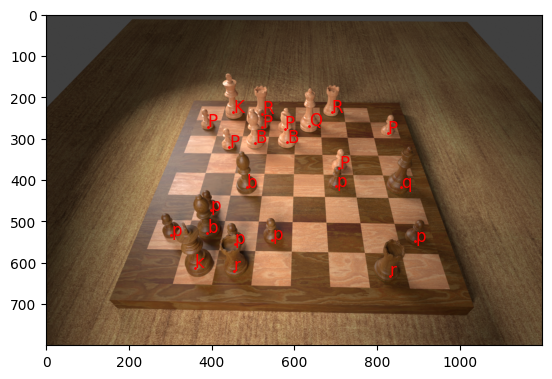

In [12]:
# predict the chess pieces
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
image_tensor = torchvision.transforms.functional.to_tensor(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
image_tensor = image_tensor.to(device)
image_tensor = image_tensor.unsqueeze(0)
model.eval()
with torch.no_grad():
    prediction = model(image_tensor)
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    threshold = 0.5
    boxes = boxes[scores >= threshold]
    labels = labels[scores >= threshold]
    position = get_position(boxes)
    result_points = point_transformation(position, H)
    outputs = label_pieces(position, labels)
    print(outputs)
    for piece in outputs:
        plt.text(piece[1], piece[2], piece[0], fontsize=12, color='red')
        plt.plot(piece[1], piece[2], 'ro', markersize=1)
plt.show()


[['k', 322.733700525405, 626.446269888251], ['p', 369.99411057497827, 588.3561140475707], ['K', 319.1631692552332, 267.7574361535753], ['p', 276.379038756858, 575.0979704908009], ['P', 527.6244157241483, 433.21582906778093], ['R', 379.7572386196163, 271.9327993623653], ['P', 328.14780396261654, 380.232970209646], ['P', 629.0403536034631, 333.3247523796082], ['P', 384.1647289390042, 317.7000914183087], ['P', 276.35181625006936, 319.0138376151823], ['Q', 476.9504923516988, 311.6285149070438], ['p', 623.4864700547474, 579.5915298421488], ['p', 421.6217208469602, 580.5903398031272], ['p', 519.3115950442071, 475.8677941404346], ['R', 524.4103291989695, 263.3160486480701], ['q', 624.9097743269136, 475.4540627063396], ['B', 375.6861791603914, 366.1864061306024], ['r', 578.283631387117, 633.2624647146781], ['b', 373.41500453183147, 481.0003784214257], ['b', 327.3615719653344, 570.3485192533478], ['r', 374.6586518844437, 629.6140337596138], ['p', 324.26198204203996, 529.7112632420808], ['B', 43

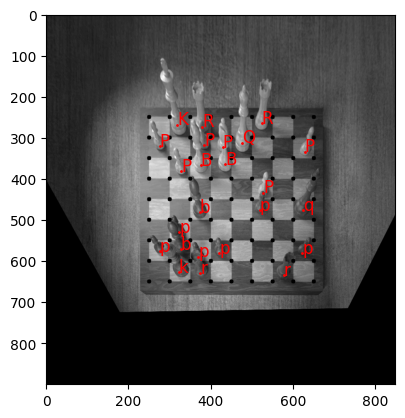

In [13]:
warped_points = point_transformation(position, H)
pieces = label_pieces(warped_points, labels)
print(pieces)
for piece in pieces:
    plt.text(piece[1], piece[2], piece[0], fontsize=12, color='red')
    plt.plot(piece[1], piece[2], 'ro', markersize=1)
plt.imshow(warped, cmap="gray")


In [14]:
def createBoard(intersections, pieces):
    """
    createBoard creates 8x8 numpy array as chess board from intersection coordinates and piece coordinates


    :param intersections: 9x9 array of coordinate points that represent corners of boxes
    :param pieces: list of lists of length 3 of the form [[PIECE, x1, y1], [PIECE, x2, y2]...]
    :return: 8x8 numpy array with pieces in correct locations
    """
    pieces_dict = {(item[1], item[2]): item[0] for item in pieces}
    board = np.full((8,8), "", dtype=object)
    for row_idx, row in enumerate(board):
        for col_idx, col in enumerate(row):
            top_left = intersections[row_idx][col_idx]
            top_right = intersections[row_idx][col_idx+1]
            bot_left = intersections[row_idx+1][col_idx]
            bot_right = intersections[row_idx+1][col_idx+1]
            for coords in pieces_dict:
                if coords[0] > top_left[0] and coords[0] <= top_right[0] and coords[1] > top_left[1] and coords[1] <= bot_right[1]:
                    board[row_idx,col_idx] = pieces_dict.get(coords)
                    break
    return board
def generateFEN(board):
    """
    generateFEN creates FEN code from 8x8 chess board list


    :param board: 8x8 chessboard with either a piece name or empty string
    :return: FEN code
    """
    count = 0
    output = ''
    for row_idx, row in enumerate(board):
        for col_idx, col in enumerate(row):
            if col != '':
                if count != 0:
                    output += str(count)
                    count = 0
                output += col
            else:
                count += 1
        if count != 0:
            output += str(count)
        if row_idx != len(board) -1:
            output += '/'
        count = 0
    return output


In [15]:
board = createBoard(intersections, pieces)
FEN = generateFEN(board)
print(FEN)


1KR2R2/P1PPQ2P/1PBB4/5P2/2b2p1q/1p6/pbpp3p/1kr3r1


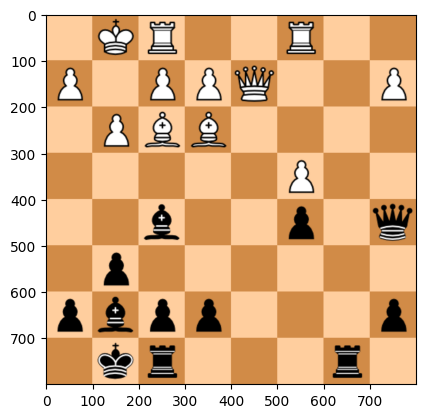

In [16]:
# visualize fen notation
from fentoboardimage import fenToImage, loadPiecesFolder
board = fenToImage(
    FEN,
    squarelength=100,
	pieceSet=loadPiecesFolder("./pieces"),
	darkColor="#D18B47",
	lightColor="#FFCE9E"
)
plt.imshow(board)
